In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

2023-04-25 13:14:43.828734: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv('data_set.csv')
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
1,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
3,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
4,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55


In [3]:
close = df['Close']
close.head()

0    233.75
1    233.25
2    234.25
3    236.10
4    233.30
Name: Close, dtype: float64

**Data Pre Processing**

In [4]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
minmax_scaler=MinMaxScaler(feature_range=(0,1))
close_minmax=minmax_scaler.fit_transform(np.array(close).reshape(-1,1))
standard_scaler = StandardScaler()
close_standard = standard_scaler.fit_transform(np.array(close).reshape(-1,1))

**Min-Max Scaling**

Train Test Split

In [5]:
training_size=int(len(close_minmax)*0.65)
test_size=len(close_minmax)-training_size
train_data,test_data=close_minmax[0:training_size,:],close_minmax[training_size:len(close_minmax),:1]

In [6]:
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [7]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [8]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [9]:
model=Sequential()
model.add(LSTM(128,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(128,return_sequences=True))
model.add(LSTM(128))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

2023-04-25 13:14:48.452679: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)


Epoch 1/100
20/20 [==============================] - 8s 198ms/step - loss: 0.0199
Epoch 2/100
20/20 [==============================] - 4s 190ms/step - loss: 0.0027
Epoch 3/100
20/20 [==============================] - 4s 196ms/step - loss: 0.0016
Epoch 4/100
20/20 [==============================] - 4s 192ms/step - loss: 0.0013
Epoch 5/100
20/20 [==============================] - 4s 191ms/step - loss: 0.0012
Epoch 6/100
20/20 [==============================] - 4s 190ms/step - loss: 0.0013
Epoch 7/100
20/20 [==============================] - 4s 193ms/step - loss: 0.0014
Epoch 8/100
20/20 [==============================] - 4s 197ms/step - loss: 0.0010
Epoch 9/100
20/20 [==============================] - 4s 180ms/step - loss: 9.8961e-04
Epoch 10/100
20/20 [==============================] - 4s 185ms/step - loss: 0.0011
Epoch 11/100
20/20 [==============================] - 5s 227ms/step - loss: 9.0422e-04
Epoch 12/100
20/20 [==============================] - 4s 216ms/step - loss: 0.0011
Epoch

In [11]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

20/20 [==============================] - 1s 56ms/step


In [12]:
# rmse 
import math
from sklearn.metrics import mean_squared_error
print("train rmse ",math.sqrt(mean_squared_error(y_train,train_predict)))
print("test rmse ",math.sqrt(mean_squared_error(ytest,test_predict)))

train rmse  0.014196580074763435
test rmse  0.014036490866413948


In [13]:
# r2 score 
from sklearn.metrics import r2_score
print("train r2 ",r2_score(y_train,train_predict))
print("test r2 ",r2_score(ytest,test_predict))

train r2  0.9941873235657614
test r2  0.9738228269681546


In [14]:
train_predict=minmax_scaler.inverse_transform(train_predict)
test_predict=minmax_scaler.inverse_transform(test_predict)
y_train = minmax_scaler.inverse_transform(y_train.reshape(-1,1))
ytest = minmax_scaler.inverse_transform(ytest.reshape(-1,1))

In [15]:
train_predict

array([[285.74216],
       [292.34494],
       [286.96497],
       ...,
       [145.90927],
       [146.48242],
       [144.69756]], dtype=float32)

In [16]:
y_train

array([[294.2 ],
       [287.8 ],
       [286.65],
       ...,
       [148.  ],
       [143.  ],
       [144.7 ]])

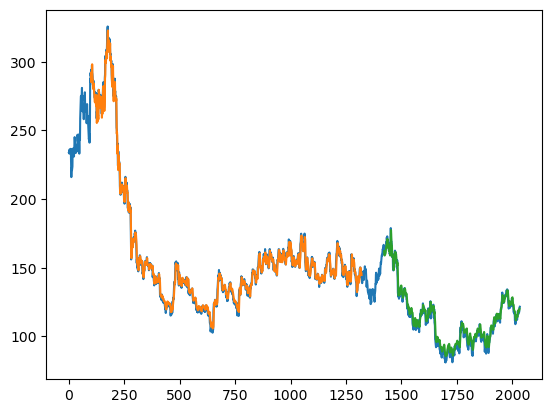

In [17]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(close_minmax)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(close_minmax)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(close_minmax)-1, :] = test_predict
# plot baseline and predictions
plt.plot(minmax_scaler.inverse_transform(close_minmax))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

**Standard Scaling**

Train Test Split

In [18]:
training_size=int(len(close_standard)*0.65)
test_size=len(close_standard)-training_size
train_data,test_data=close_standard[0:training_size,:],close_standard[training_size:len(close_standard),:1]

In [19]:
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [20]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [21]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [22]:
model=Sequential()
model.add(LSTM(128,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(128,return_sequences=True))
model.add(LSTM(128))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [23]:
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)


Epoch 1/100
20/20 [==============================] - 8s 206ms/step - loss: 0.1718
Epoch 2/100
20/20 [==============================] - 4s 211ms/step - loss: 0.0406
Epoch 3/100
20/20 [==============================] - 4s 201ms/step - loss: 0.0320
Epoch 4/100
20/20 [==============================] - 4s 200ms/step - loss: 0.0231
Epoch 5/100
20/20 [==============================] - 4s 201ms/step - loss: 0.0215
Epoch 6/100
20/20 [==============================] - 4s 201ms/step - loss: 0.0184
Epoch 7/100
20/20 [==============================] - 4s 205ms/step - loss: 0.0192
Epoch 8/100
20/20 [==============================] - 4s 203ms/step - loss: 0.0163
Epoch 9/100
20/20 [==============================] - 4s 211ms/step - loss: 0.0169
Epoch 10/100
20/20 [==============================] - 4s 209ms/step - loss: 0.0189
Epoch 11/100
20/20 [==============================] - 4s 210ms/step - loss: 0.0290
Epoch 12/100
20/20 [==============================] - 5s 232ms/step - loss: 0.0183
Epoch 13/100


In [24]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

20/20 [==============================] - 1s 55ms/step


In [25]:
# rmse 
import math
from sklearn.metrics import mean_squared_error
print("train rmse ",math.sqrt(mean_squared_error(y_train,train_predict)))
print("test rmse ",math.sqrt(mean_squared_error(ytest,test_predict)))

train rmse  0.07273994351401503
test rmse  0.05856716859734668


In [26]:
# r2 score 
from sklearn.metrics import r2_score
print("train r2 ",r2_score(y_train,train_predict))
print("test r2 ",r2_score(ytest,test_predict))

train r2  0.9939606396142311
test r2  0.9819635750988553


In [27]:
train_predict=standard_scaler.inverse_transform(train_predict)
test_predict=standard_scaler.inverse_transform(test_predict)
y_train = standard_scaler.inverse_transform(y_train.reshape(-1,1))
ytest = standard_scaler.inverse_transform(ytest.reshape(-1,1))

In [28]:
# rmse 
import math
from sklearn.metrics import mean_squared_error
print("train rmse ",math.sqrt(mean_squared_error(y_train,train_predict)))
print("test rmse ",math.sqrt(mean_squared_error(ytest,test_predict)))

train rmse  3.5424398040700416
test rmse  2.8522250025952047


In [29]:
# r2 score 
from sklearn.metrics import r2_score
print("train r2 ",r2_score(y_train,train_predict))
print("test r2 ",r2_score(ytest,test_predict))

train r2  0.993960641548265
test r2  0.981963578036019


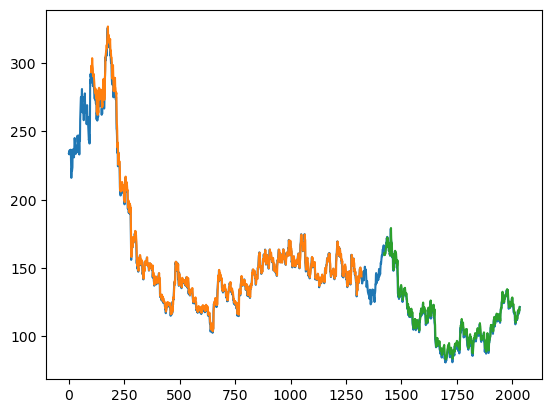

In [30]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(close_standard)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(close_standard)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(close_standard)-1, :] = test_predict
# plot baseline and predictions
plt.plot(standard_scaler.inverse_transform(close_standard))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()